<a href="https://colab.research.google.com/github/nan-hk/-motion-artifacts/blob/master/Image_Enhancement_WIth_MIRNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/data_3D.zip", 'r')
zip_ref.extractall("/content/tmp")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
##2D to Image

In [ ]:
import numpy as np
import os    # Traverse folders 
import nibabel as nib #nii Format 1 This bag will be used in general 
import imageio   # Convert to an image 
 
def nii_to_image(niifile):
 filenames = os.listdir(os.path.join(filepath, imgfile)) # Read nii Folder 
 slice_trans = []
 for f in filenames:
  # Start reading nii Documents 
  img_path = os.path.join(filepath, imgfile, f)
  img = nib.load(img_path)    # Read nii
  img_fdata = img.get_fdata()
  fname = f.replace('.nii','')   # Remove nii Suffix name of 
  img_f_path = os.path.join(filepath1, imgfile)
  # Create nii The folder of the corresponding image 
  if not os.path.exists(img_f_path):
   os.mkdir(img_f_path)    # New Folder 
 
  # Start converting to an image 
  (x,y,z) = img.shape
  for i in range(z):      #z Is a sequence of images 
   silce = img_fdata[:, :, i]   # You can choose which direction of slice 
   imageio.imwrite(os.path.join(filepath1, img_f_path, fname + '{}.png'.format(i)), silce)
            # Save an image 
 
if __name__ == '__main__':
 imgs =['GT/', 'Label/']
for i in imgs:
 filepath = '/content/tmp/data_3D/'
 filepath1 = '/content/tmp/data_2D/'
 imgfile = i
 nii_to_image(filepath)

In [ ]:
import os
import cv2
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
random.seed(10)

IMAGE_SIZE = 128
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 400
VAL_TRAIN_IMAGES = 600


def read_image(image_path):
    print(image_path)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("/content/tmp/data_2D/Label/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("/content/tmp/data_2D/GT/*"))[:MAX_TRAIN_IMAGES]
print(len(train_low_light_images))

val_low_light_images = sorted(glob("/content/tmp/data_2D/Label/*"))[:VAL_TRAIN_IMAGES]
val_enhanced_images = sorted(glob("/content/tmp/data_2D/GT/*"))[:VAL_TRAIN_IMAGES]
print(len(val_low_light_images))

test_low_light_images = sorted(glob("/content/tmp/data_2D/Label/*"))[VAL_TRAIN_IMAGES:]
test_enhanced_images = sorted(glob("/content/tmp/data_2D/GT/*"))[VAL_TRAIN_IMAGES:]
print(len(test_low_light_images))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

400
600
6
Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)
Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>


In [ ]:
def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
    )
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
    compact_feature_representation = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

In [ ]:

def spatial_attention_block(input_tensor):
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = layers.Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])


In [ ]:
# Recursive Residual Modules


def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau), level2_dau, up_sampling_module(level3_dau)
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level3_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])


In [ ]:

def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=64)

Epoch 1/5
100/100 [==============================] - 460s 4s/step - loss: 0.0340 - peak_signal_noise_ratio: 76.8941 - val_loss: 0.0116 - val_peak_signal_noise_ratio: 83.4946 - lr: 1.0000e-04
Epoch 2/5
100/100 [==============================] - 407s 4s/step - loss: 0.0155 - peak_signal_noise_ratio: 82.7820 - val_loss: 0.0089 - val_peak_signal_noise_ratio: 86.6498 - lr: 1.0000e-04
Epoch 3/5
100/100 [==============================] - 407s 4s/step - loss: 0.0113 - peak_signal_noise_ratio: 85.2988 - val_loss: 0.0082 - val_peak_signal_noise_ratio: 87.7207 - lr: 1.0000e-04
Epoch 4/5
100/100 [==============================] - 405s 4s/step - loss: 0.0097 - peak_signal_noise_ratio: 86.5942 - val_loss: 0.0077 - val_peak_signal_noise_ratio: 88.4432 - lr: 1.0000e-04
Epoch 5/5
100/100 [==============================] - 405s 4s/step - loss: 0.0089 - peak_signal_noise_ratio: 87.4740 - val_loss: 0.0074 - val_peak_signal_noise_ratio: 88.9584 - lr: 1.0000e-04


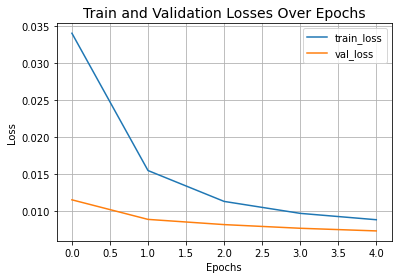

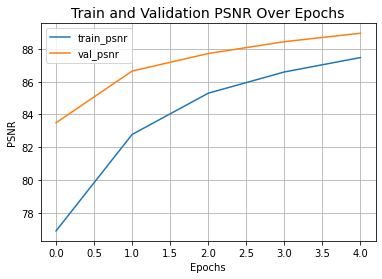

In [ ]:

def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
import cv2
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    img_bytes = tf.io.read_file(original_image)
    image = tf.image.decode_png(img_bytes, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [128,128], method='nearest')
    print(image.shape)
    image = tf.cast(image, dtype=tf.float32) / 255.0
    image = np.expand_dims(image, axis=0)
    #image = keras.preprocessing.image.img_to_array(original_image)  
    #image = image.astype("float32") / 255.0
    #image = np.expand_dims(image, axis=-1)
    output = model.predict(image)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = Image.fromarray(np.uint8(output_image.astype(int)))
    #original_image = Image.fromarray(np.uint8(image.astype(int)))
    return output_image


<PIL.PngImagePlugin.PngImageFile image mode=L size=150x256 at 0x7FDD7D2E2E50>
(128, 128, 3)


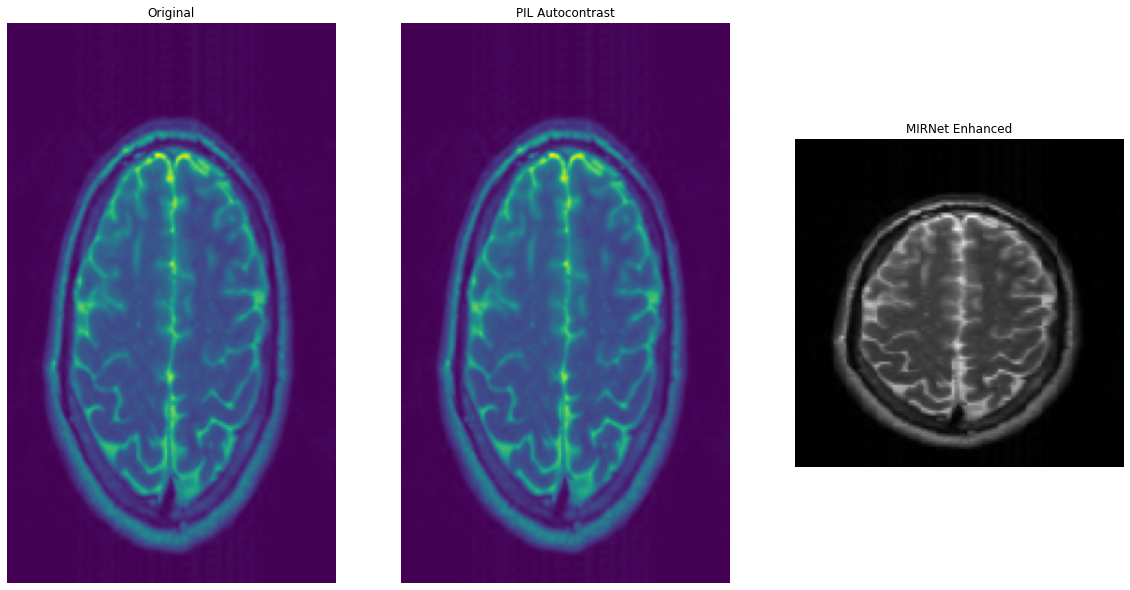

<PIL.PngImagePlugin.PngImageFile image mode=L size=150x256 at 0x7FDD7D2F1AD0>
(128, 128, 3)


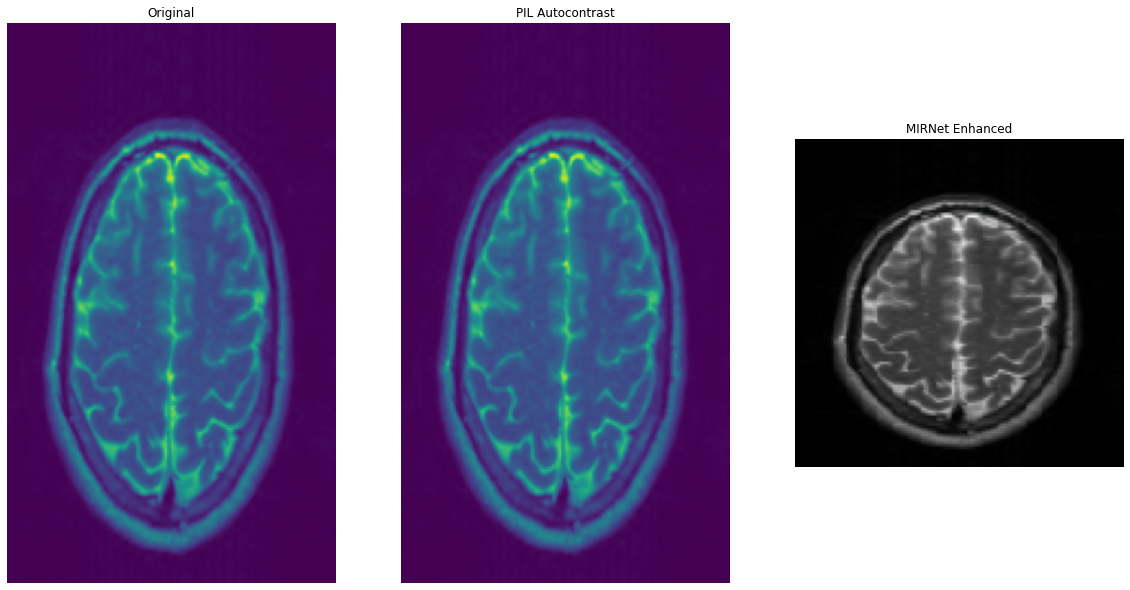

<PIL.PngImagePlugin.PngImageFile image mode=L size=150x256 at 0x7FDD7D0AE210>
(128, 128, 3)


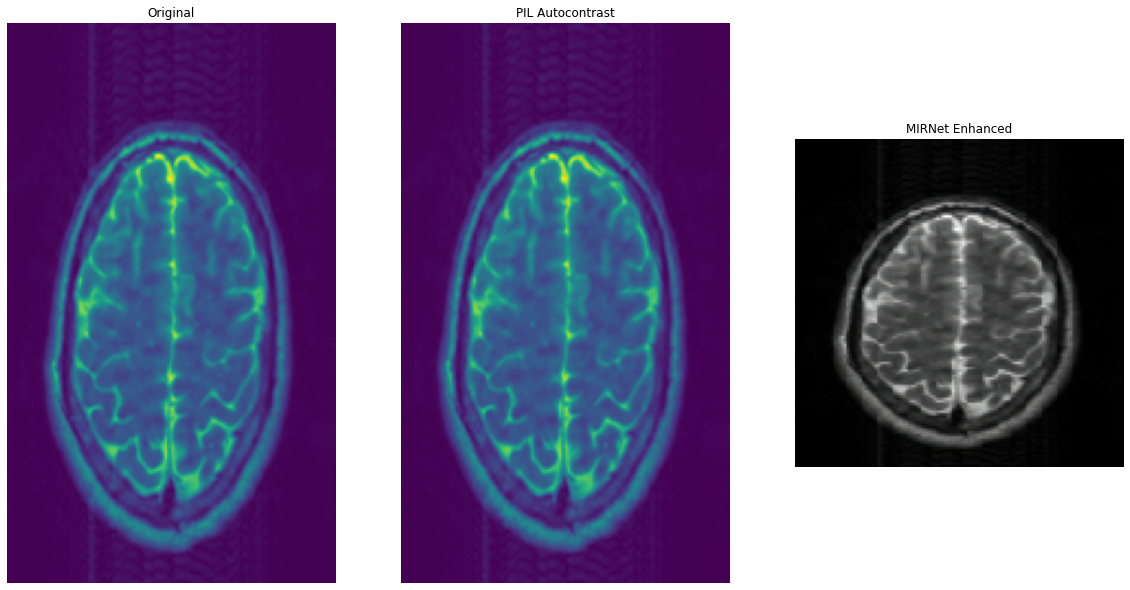

In [ ]:

for low_light_image in random.sample(test_low_light_images, 3):
    original_image = Image.open(low_light_image)
    print(original_image)
    enhanced_image = infer(low_light_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
        (20, 12),
    )